# This notebook preprocesses the raw data
### from quality control to creating a clean aggregate data set

Input: raw data in the raw_data folder

Output: clean data in csv form in processed_data folder

Imports

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from scipy.io import loadmat
import json
import jsonpickle as pickle

Set global variables and propertes

In [2]:
raw_data_fname_str = ""
raw_data_folder = "raw_data"
choice_data_folder = os.path.join(raw_data_folder, "choices")
questionnaire_data_folder = os.path.join(raw_data_folder, "questionnaires")

results_folder = os.path.join("results")
processed_data_folder = os.path.join("processed_data")

sorted_data_fname = "sorted_data.csv"
sorted_data_file = os.path.join(processed_data_folder, sorted_data_fname)

plot_df_fname = "plot_df_data.csv"
plot_data_file = os.path.join(processed_data_folder, plot_df_fname)

second_level_fname = "second_level_data.csv"
second_level_file = os.path.join(processed_data_folder, second_level_fname)

mask_file_name = "mask.txt"
mask_file = os.path.join(processed_data_folder, mask_file_name)

Rho_fname = "Rho.pkl"
Rho_file = os.path.join(processed_data_folder, Rho_fname)

agent_data_fname = "data_formatted_for_agent.pkl"
agent_data_file = os.path.join(processed_data_folder, agent_data_fname)

statistics_folder = os.path.join(results_folder, "statistics")

In [3]:
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# make global parameter dict:
global_experiment_parameters = {"T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward}

make subject list

In [4]:
os.listdir(choice_data_folder)

subject_dict = {}
game_files = []
config_files = []

for i, file in enumerate(os.listdir(choice_data_folder)):
    if "game" in file:
        subject_dict[str(i)] = file[:5]
        game_files.append(os.path.join(choice_data_folder, file))
        assert file[:5]+"_config.txt" in os.listdir(choice_data_folder)
        config_files.append(os.path.join(choice_data_folder, file[:5]+"_config.txt"))

print(subject_dict)

nsubs = len(game_files)

{'0': '17946', '3': '04960', '4': '61120', '5': '55027', '6': '04862', '9': '35102', '11': '23849', '15': '63520', '22': '92975', '26': '57653', '34': '16691', '35': '04936', '36': '09695', '40': '68012', '43': '75759', '50': '99461', '57': '97543', '59': '33765', '65': '46080', '68': '53366', '70': '03187', '74': '88310', '75': '99845', '79': '10951'}


In [5]:
subject_configs = []

for i, config_file in enumerate(config_files):
    config = open(config_file, "r").read()
    if config[25:29] == "blue":
        subject_configs.append("normal")
    elif config[25:29] == "pink":
        subject_configs.append("reverse")
    else:
        print("non standard config")
        print(config)

In [6]:
subject_dataframes = []
sub_trials = []

for i, game_file in enumerate(game_files):
    subject_dataframes.append(pd.read_csv(game_file))
    sub_trials.append(subject_dataframes[-1]["trial"].values[-1]+1)

In [7]:
sub_1 = subject_dataframes[0]

In [8]:
sub_1

,trial,common,reward.1.1,reward.1.2,reward.2.1,reward.2.2,isymbol_lft,isymbol_rgt,rt1,choice1,final_state,fsymbol_lft,fsymbol_rgt,rt2,choice2,reward,slow
0,0,1,0.301804,0.598626,0.391133,0.713132,1,2,-1.000000,-1,-1,-1,-1,-1.000000,-1,0,1
1,1,1,0.290235,0.576636,0.431357,0.675460,2,1,0.895979,1,1,1,2,1.484417,1,0,0
2,2,1,0.284366,0.604035,0.427209,0.629951,2,1,0.697615,1,1,1,2,1.038017,1,0,0
3,3,0,0.333168,0.583050,0.387057,0.611255,2,1,0.592445,1,2,2,1,1.218122,2,1,0
4,4,1,0.278080,0.582827,0.368955,0.560808,2,1,0.511351,2,2,2,1,1.144978,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,199,0,0.395417,0.475090,0.430382,0.566529,1,2,0.561999,1,2,1,2,1.395664,1,0,0
200,200,1,0.418047,0.478136,0.388214,0.540363,2,1,0.675478,1,1,2,1,0.583900,2,0,0
201,201,1,0.426285,0.489194,0.396737,0.538484,2,1,1.135383,1,1,2,1,0.606567,1,0,0
202,202,1,0.420192,0.459044,0.420311,0.504456,1,2,1.219594,2,2,2,1,0.557494,2,0,0


In [9]:
trials =  np.amax(np.array(sub_trials))#number of trials
print(trials)
global_experiment_parameters["trials"] = trials

Rho = np.zeros((nsubs, trials, nr, ns))

for i, sub_df in enumerate(subject_dataframes):
    Rho[i,:sub_trials[i],1,:never_reward] = 0.
    Rho[i,:sub_trials[i],0,:never_reward] = 1.
    Rho[i,:sub_trials[i],1,never_reward+0] = sub_df["reward.1.1"].values
    Rho[i,:sub_trials[i],0,never_reward+0] = 1.-sub_df["reward.1.1"].values
    Rho[i,:sub_trials[i],1,never_reward+1] = sub_df["reward.1.2"].values
    Rho[i,:sub_trials[i],0,never_reward+1] = 1.-sub_df["reward.1.2"].values
    Rho[i,:sub_trials[i],1,never_reward+2] = sub_df["reward.2.1"].values
    Rho[i,:sub_trials[i],0,never_reward+2] = 1.-sub_df["reward.2.1"].values
    Rho[i,:sub_trials[i],1,never_reward+3] = sub_df["reward.2.2"].values
    Rho[i,:sub_trials[i],0,never_reward+3] = 1.-sub_df["reward.2.2"].values

global_experiment_parameters["Rho"] = Rho

272


plot subject reward trajectories

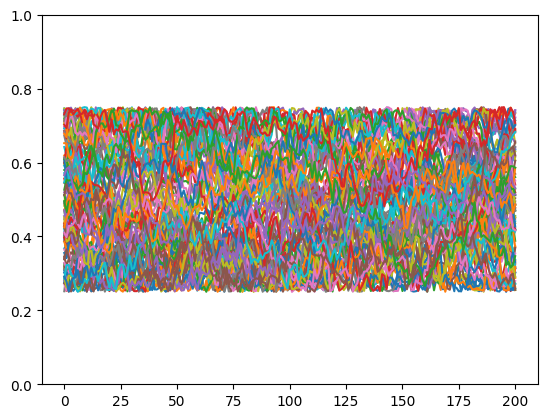

In [10]:
plt.figure()
for subj in range(nsubs):
    plt.plot(Rho[subj,:sub_trials[i],1,never_reward:])
    # print(Rho[subj,:sub_trials[i],1,never_reward:])

plt.ylim([0,1])
plt.show()

example trajectories

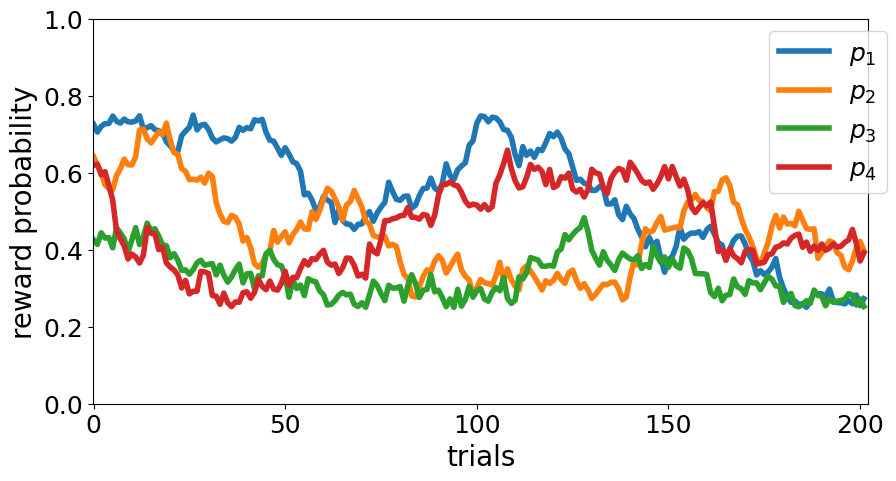

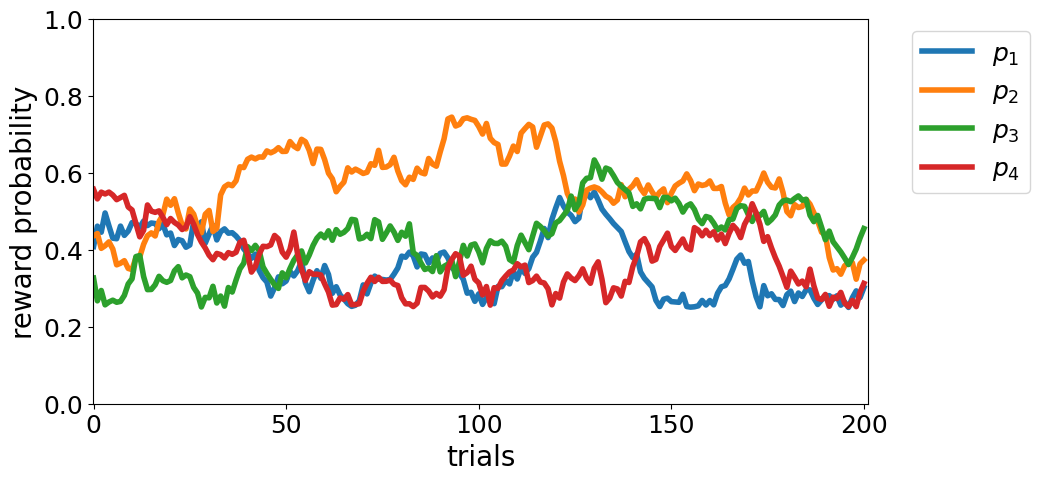

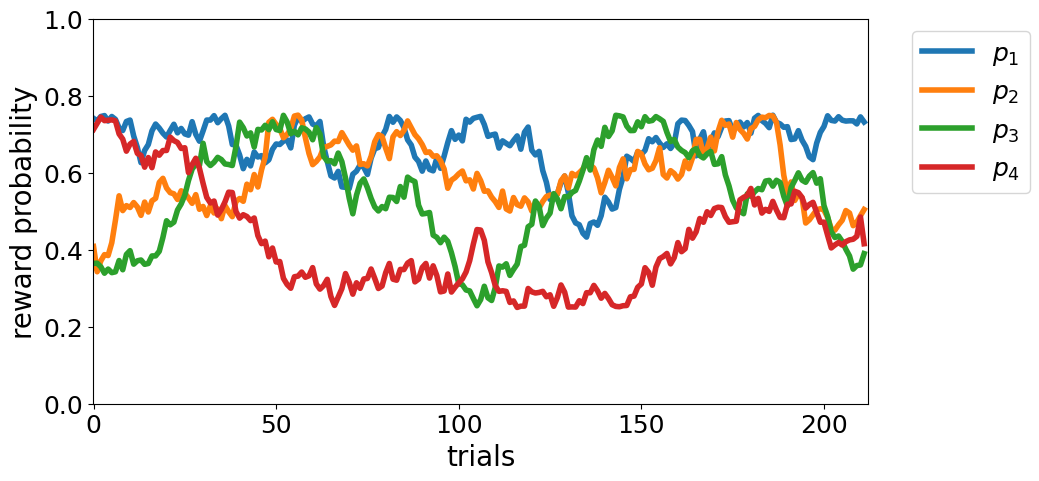

In [11]:
example_subs = [2, 5, 11]

for subj in example_subs:
    plt.figure(figsize=(10,5))
    for i in range(4):
        plt.plot(Rho[subj,:sub_trials[subj],1,3+i], label="$p_{}$".format(i+1), linewidth=4)
    plt.ylim([0,1])
    plt.yticks(np.arange(0,1.1,0.2),fontsize=18)
    plt.ylabel("reward probability", fontsize=20)
    plt.xlim([-0.1, sub_trials[subj]+0.1])
    plt.xticks(range(0,sub_trials[subj]+1,50),fontsize=18)
    plt.xlabel("trials", fontsize=20)
    plt.legend(fontsize=18, bbox_to_anchor=(1.04,1))
    plt.savefig(os.path.join(statistics_folder, str(subj)+"_twostep_prob.svg"),dpi=300)
    plt.show()


Create test data frame

In [12]:
processed_data = pd.DataFrame({"subject": [], "trial": [], "valid": [], 
                               "choices first stage": [], "choices second stage": [], 
                               "RTs first stage": [], "RTs second stage": [], 
                               "states first stage": [], "states second stage": [], 
                               "outcomes first stage": [], "outcomes second stage": []})

read out relevant info and restructure

In [13]:
def format_data(subj, subj_df, subj_trials, subj_config):

    print(subj)

    subj_arr = np.array([subj]*trials)

    trial_arr = np.array(list(range(trials)))

    valid_arr = np.zeros(trials).astype(bool)
    valid_arr[:subj_trials] = np.logical_not(subj_df["slow"].astype(bool))

    first_stage_actions = np.zeros(trials).astype(int) - 1
    first_stage_actions[:subj_trials] = subj_df["choice1"].astype(int) - 1

    second_stage_actions = np.zeros(trials).astype(int) - 1
    second_stage_actions[:subj_trials] = subj_df["choice2"].astype(int) - 1

    # RTs_first_stage_arr = np.zeros(trials).astype(float) - 1
    # RTs_first_stage_arr[:subj_trials] = subj_df["rt1"].astype(float)

    # RTs_second_stage_arr = np.zeros(trials).astype(float) - 1
    # RTs_second_stage_arr[:subj_trials] = subj_df["rt2"].astype(float)

    #### note: the following is used in simulations throughout this repo:
    # s = 0: t=0; initial state before first action
    # s = 1: t=1; after choosing a1 = 0 (common)
    # s = 2: t=1; after choosing a2 = 1 (common)
    # s = 3: t=2; after choosing a1 = 0 from s=1
    # s = 4: t=2; after choosing a1 = 0 from s=2
    # s = 5: t=2; after choosing a1 = 1 from s=1
    # s = 6: t=2; after choosing a1 = 1 from s=2

    states1 = np.zeros(trials).astype(int) - 1
    states1[:subj_trials] = 0

    states2 = np.zeros(trials).astype(int) - 1
    assert subj_config in ["normal", "reverse"]
    # print(subj_config)
    if True:#subj_config=="normal":
        states2[:subj_trials] = subj_df["final_state"].astype(int)
    else:
        states2[:subj_trials] = -(subj_df["final_state"] - 3).astype(int)
        states2[:subj_trials][states2[:subj_trials]>2] = -1
        print(subj)
        print("real data")
        print(subj_df["final_state"].astype(int)[:10])
        print("converted data")
        print(states2[:subj_trials][:10])

    # the following calculation follows from the state and action and transition dynamics above
    states3 = np.zeros(trials).astype(int) - 1
    states3[:subj_trials] = states2[:subj_trials]+2 + first_stage_actions[:subj_trials]*2

    first_stage_rewards = np.zeros(trials).astype(int) - 1
    first_stage_rewards[:subj_trials] = 0

    second_stage_rewards = np.zeros(trials).astype(int) - 1
    second_stage_rewards[:subj_trials] = subj_df["reward"].astype(int)

    common_transition = np.zeros(trials).astype(bool)
    common_transition[:subj_trials] = subj_df["common"].astype(bool)

    np.testing.assert_allclose(common_transition[valid_arr], 
                                    states2[valid_arr]==(first_stage_actions[valid_arr]+1))

    rewarded = np.zeros(trials).astype(bool)
    rewarded[:subj_trials] = subj_df["reward"].astype(bool)

    repeated_actions = np.zeros(trials).astype(bool)
    repeated_actions[:subj_trials-1] = first_stage_actions[:subj_trials-1] == first_stage_actions[1:subj_trials]

    small_data_dict = {"subject": subj_arr, "trials": trial_arr, "valid": valid_arr,
                       "first_action": first_stage_actions, "second_action": second_stage_actions,
                       "rewards": second_stage_rewards, "common": common_transition,
                       "rewarded": rewarded, "repeated": repeated_actions}
    
    small_data_df = pd.DataFrame(small_data_dict)

    # now re-format for big df

    miniblock_index = np.array(list(range(trials)) + list(range(trials)))
    step_index = np.array([1]*trials + [2]*trials)

    formatted_subject_arr = np.append(subj_arr, subj_arr)

    formatted_valid_arr = np.append(valid_arr, valid_arr)

    formatted_actions = np.append(first_stage_actions, second_stage_actions)

    formatted_rewards = np.append(first_stage_rewards, second_stage_rewards)

    formatted_states = np.append(states2, states3)

    formatted_rewarded = np.append(rewarded, rewarded)

    formatted_repeated = np.append(repeated_actions, repeated_actions)

    formatted_common = np.append(common_transition, common_transition)

    data_dict = {"actions": formatted_actions, "rewards": formatted_rewards,
                    "states": formatted_states, "subject": formatted_subject_arr,
                    "miniblock_index": miniblock_index, "step_index": step_index,
                    "common": formatted_common, "mask": formatted_valid_arr,
                    "repeated_actions": formatted_repeated, "rewarded": formatted_rewarded
                    }

    data_df = pd.DataFrame(data_dict)

    # re-format for plotting
    rew_names = ["unrewarded", "rewarded"]
    named_rewarded = [rew_names[int(i)] for i in rewarded]
    common_names = ["rare", "common"]
    named_common = [common_names[int(i)] for i in common_transition]
    plotting_data_dict = {"rewarded": named_rewarded, "common": named_common, 
                          "stayed": repeated_actions.astype(int), "valid": valid_arr}
    plotting_data_df = pd.DataFrame(plotting_data_dict)

    # and re-format for agent

    agent_outcome_dict = {"subject": subj_arr, "observations": np.stack([states1, states2, states3], axis=1), 
                    "actions": np.stack([first_stage_actions, second_stage_actions], axis=1), 
                    "valid": valid_arr, "rewards": np.stack([first_stage_rewards, second_stage_rewards], axis=1)}

    return data_df, plotting_data_df, small_data_df, agent_outcome_dict

In [14]:
data_dict = {"actions": np.array([]).astype(int), "rewards": np.array([]).astype(int),
                    "states": np.array([]).astype(int), "subject": np.array([]).astype(int),
                    "miniblock_index": np.array([]).astype(int), "step_index": np.array([]).astype(int),
                    "common": np.array([]).astype(bool), "mask": np.array([]).astype(bool),
                    "repeated_actions": np.array([]).astype(bool), "rewarded": np.array([]).astype(bool)
                    }

all_data_df = pd.DataFrame(data_dict)

small_data_dict = {"subject": [], "trials": [], "valid": [],
                       "first_action": [], "second_action": [],
                       "rewards": [], "common": [],
                       "rewarded": [], "repeated": []}
all_small_df = pd.DataFrame(small_data_dict)

stayed_dict = {"subject": [], "rewarded": [], "common": [], "stayed": []}
stayed_df = pd.DataFrame(stayed_dict)

all_plotting_data_df = pd.DataFrame({"rewarded": [], "common": [], 
                          "stayed": [], "valid": []})

agent_outcome_list = []

for s in range(nsubs):

    # print(subject_dict[str(s)])
    # format_data(s, subject_dataframes[s], sub_trials[s], subject_configs[s])
    sorted_subj_data, plotting_data_df, small_data_df, agent_outcome_dict = format_data(s, subject_dataframes[s], sub_trials[s], subject_configs[s])

    # groupby returns as shown below -> rewarded_common = 0, unrewarded_commen = 1,, rewarded_rare = 2 unrewarded_rare = 3, 
    # print(plotting_data_df.groupby(["common", "rewarded"])["stayed"].mean())
    second_level_vals = plotting_data_df[plotting_data_df["valid"]==True].groupby(["common", "rewarded"])["stayed"].mean()
    # print(second_level_vals)
    second_level_dict = {"subject": [s]*4, "rewarded": ["rewarded", "unrewarded"]*2, 
                         "common": ["common"]*2+["rare"]*2, "stayed": second_level_vals.values}
    stayed_df = pd.concat([stayed_df, pd.DataFrame(second_level_dict)], join="inner")

    all_plotting_data_df = pd.concat([all_plotting_data_df, plotting_data_df], join="inner")

    all_data_df = pd.concat([all_data_df, sorted_subj_data], join="inner")

    all_small_df = pd.concat([all_small_df, small_data_df], join="inner")

    agent_outcome_list.append(agent_outcome_dict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


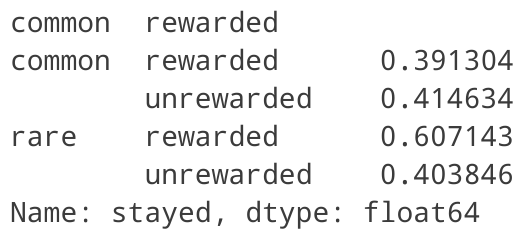

In [15]:
stayed_df

,subject,rewarded,common,stayed
0,0.0,rewarded,common,0.971831
1,0.0,unrewarded,common,0.385714
2,0.0,rewarded,rare,0.233333
3,0.0,unrewarded,rare,0.900000
0,1.0,rewarded,common,0.420290
...,...,...,...,...
3,22.0,unrewarded,rare,0.857143
0,23.0,rewarded,common,0.908046
1,23.0,unrewarded,common,0.577778
2,23.0,rewarded,rare,0.769231


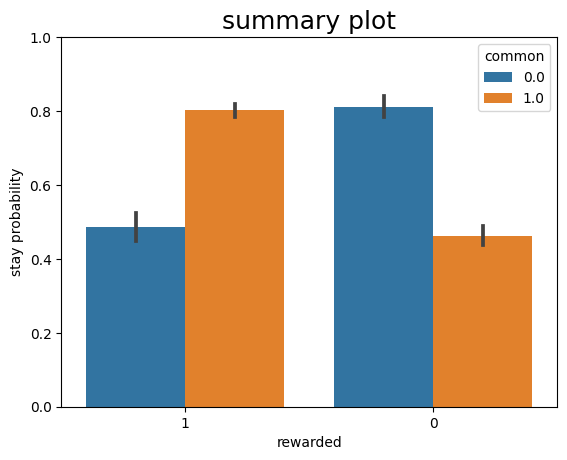

In [16]:
plt.figure()
g = sns.barplot(data=all_small_df[all_small_df["valid"]==True], x="rewarded", y="repeated", hue="common", order=[1, 0])
#g.set_xticklabels(names, rotation=45, horizontalalignment='right', fontsize=16)
plt.ylim([0,1])
# plt.yticks(np.arange(0,1.1,0.2),fontsize=16)
plt.title("summary plot", fontsize=18)
# plt.savefig(os.path.join(statistics_folder, "behavior_summary_plot_df.svg"),dpi=300)
plt.ylabel("stay probability")
plt.show()

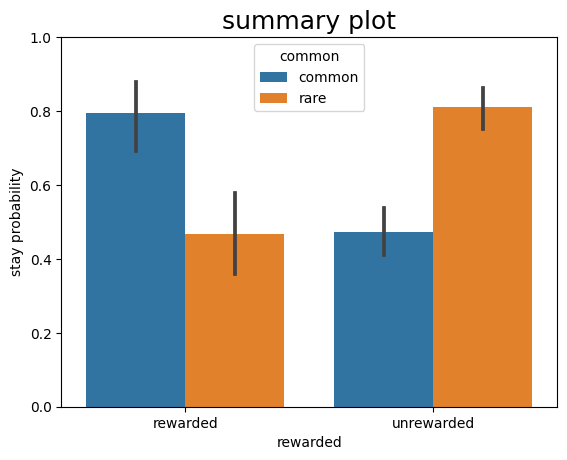

In [17]:
plt.figure()
g = sns.barplot(data=stayed_df, x="rewarded", y="stayed", hue="common", order=["rewarded", "unrewarded"])
#g.set_xticklabels(names, rotation=45, horizontalalignment='right', fontsize=16)
plt.ylim([0,1])
# plt.yticks(np.arange(0,1.1,0.2),fontsize=16)
plt.title("summary plot", fontsize=18)
plt.savefig(os.path.join(statistics_folder, "behavior_summary_second_level_df.svg"),dpi=300)
plt.ylabel("stay probability")
plt.show()

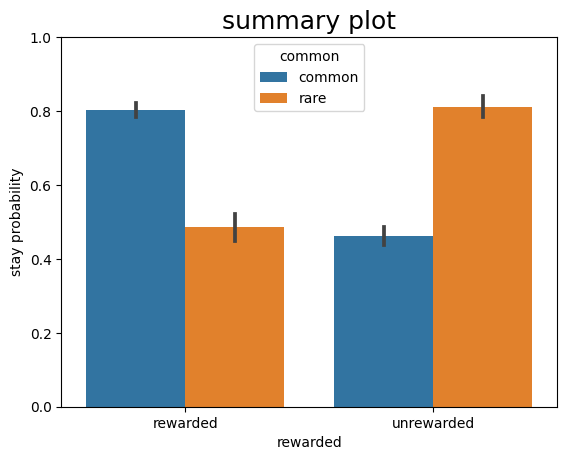

In [18]:
plt.figure()
g = sns.barplot(data=all_plotting_data_df[all_plotting_data_df["valid"]==True], x="rewarded", y="stayed", hue="common", order=["rewarded", "unrewarded"])
#g.set_xticklabels(names, rotation=45, horizontalalignment='right', fontsize=16)
plt.ylim([0,1])
# plt.yticks(np.arange(0,1.1,0.2),fontsize=16)
plt.title("summary plot", fontsize=18)
plt.savefig(os.path.join(statistics_folder, "behavior_summary_plot_df.svg"),dpi=300)
plt.ylabel("stay probability")
plt.show()

Save as CSV

In [19]:
all_data_df.to_csv(sorted_data_file)

all_plotting_data_df.to_csv(plot_data_file)

stayed_df.to_csv(second_level_file)

mask_file_name = "mask.txt"
mask_file = os.path.join(processed_data_folder, mask_file_name)

pickled_Rho = pickle.encode(Rho)
with open(Rho_file, 'w') as outfile:
    json.dump(pickled_Rho, outfile)

pickled_outcomes = pickle.encode(agent_outcome_list)
with open(agent_data_file, 'w') as outfile:
    json.dump(pickled_outcomes, outfile)

Read the CSV to test that writing worked

In [20]:
test_data = pd.read_csv(sorted_data_file)

print("sorted data:")
print(test_data)

test_data = pd.read_csv(plot_data_file)

print("\n\nplot df data")
print(test_data)

test_data = pd.read_csv(second_level_file)

print("\n\nsecond level data")
print(test_data)

with open(Rho_file, 'r') as infile:
    loaded = json.load(infile)
test_data = pickle.decode(loaded)

print("\n\nRho")
print(test_data)

with open(agent_data_file, 'r') as infile:
    loaded = json.load(infile)
test_data = pickle.decode(loaded)

print("\n\ndata formatted for agent")
print(test_data)

sorted data:
       Unnamed: 0  actions  rewards  states  subject  miniblock_index  \
0               0       -2        0      -1        0                0   
1               1        0        0       1        0                1   
2               2        0        0       1        0                2   
3               3        0        0       2        0                3   
4               4        1        0       2        0                4   
...           ...      ...      ...     ...      ...              ...   
13051         539       -1       -1      -1       23              267   
13052         540       -1       -1      -1       23              268   
13053         541       -1       -1      -1       23              269   
13054         542       -1       -1      -1       23              270   
13055         543       -1       -1      -1       23              271   

       step_index  common   mask  repeated_actions  rewarded  
0               1    True  False             Fa